In [23]:
%matplotlib inline
%config InlineBackend.figure_format = "retina"

from matplotlib import rcParams
rcParams["savefig.dpi"] = 100
rcParams["font.size"] = 20 

In [24]:
import sys
sys.path.insert(0, "./code")

In [25]:
import emcee
import load_data
import numpy as np
import matplotlib.pyplot as pl
from IPython.display import Math

We'll need to know the total number of stars in the Petigura sample in a few different places below:

In [26]:
nstar = 42557.

Now, we'll load up a binned representation of the detection efficiency map:

In [27]:
censor = load_data.load_detection_efficiency()

And the catalog of candidates (we'll only consider the ones in the range used for extrapolation):

In [30]:
_, data, _ = load_data.load_candidates()
data = np.log(data)

lpmn, lpmx = np.log(50), np.log(400)
lrmn, lrmx = np.log(1), np.log(2)

m = (lpmn < data[:, 0]) * (data[:, 0] < lpmx) * (lrmn < data[:, 1]) * (data[:, 1] < lrmx)
data = data[m]

## What Petigura et al. did...

Now, let's do the extrapolation that Petigura did:

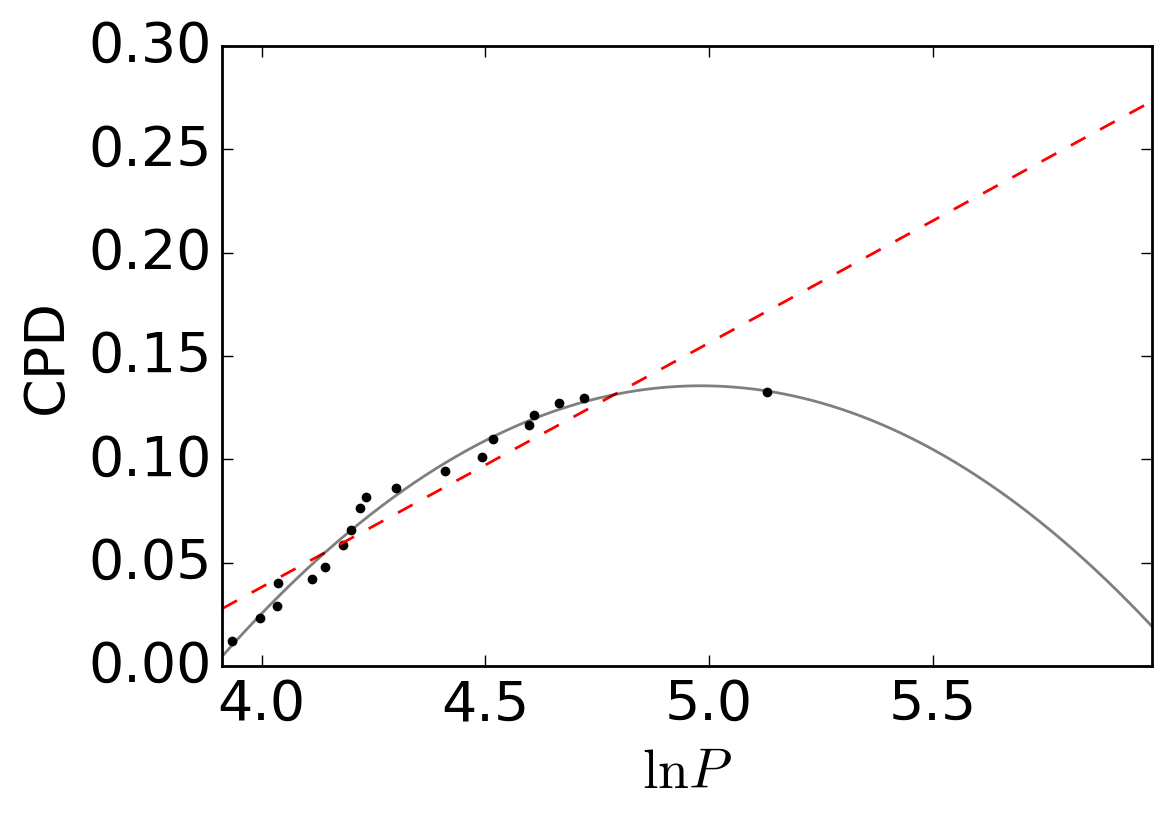

In [31]:
# Get the detection efficiency for every entry in the catalog.
w = np.exp(censor.get_lnprob(data))

# Compute the cumulative period distribution.
i = np.argsort(data[:, 0])
cpd = np.cumsum(w[i])
pl.plot(data[i, 0], cpd, ".k")

# And fit a line.
p = np.polyfit(data[i, 0], cpd, 1)
x = [lpmn, lpmx]
pl.plot(x, np.polyval(p, x), "--r")

# Just for comparison, we'll also fit a quadratic...
p2 = np.polyfit(data[i, 0], cpd, 2)
x = np.linspace(lpmn, lpmx, 5000)
pl.plot(x, np.polyval(p2, x), "k", alpha=0.5)

pl.xlim(lpmn, lpmx)
pl.xlabel("$\ln P$")
pl.ylabel("CPD");

The slope of this line gives us Petigura's estimate of $\Gamma_\oplus$:

In [32]:
Math(r"\Gamma_\oplus = {0:.3f}".format(p[0]))

<IPython.core.display.Math object>

## What Petigura et al. "should" have done...

Under the assumption of a flat (in log) bin in the range $1\,R_\oplus \le R < 2\,R_\oplus$ and $50\,\mathrm{days} \le P < 400\,\mathrm{days}$, the inverse-detection-efficiency approximation is:

$$\Gamma = \frac{1}{\Delta} \sum_k \frac{1}{Q(w_k)}$$

which gives:

In [33]:
v = np.sum(1. / w) / nstar / ((lpmx - lpmn) * (lrmx - lrmn))
Math(r"\Gamma_\oplus = {0:.3f} \pm {1:.3f}".format(v, v / np.sqrt(len(data))))

<IPython.core.display.Math object>

But that's obviously wrong because the completeness is zero in most of the bin and high for all of the detections.
So, as we derived in the paper, the better version is:

$$\Gamma = \frac{K}{\int_\Delta Q(w)\,\mathrm{d}w} $$

giving:

In [34]:
# Estimate the integral using Monte Carlo.
K = 100000
samples = np.vstack([
    np.random.uniform(lpmn, lpmx, size=K),
    np.random.uniform(lrmn, lrmx, size=K),
]).T
Q = np.exp(censor.get_lnprob(samples))

# Compute the estimate of \Gamma.
mu = len(data) / (np.mean(Q) * nstar)
std = mu / np.sqrt(len(data))
Math(r"\Gamma_\oplus = {0:.3f} \pm {1:.3f}".format(mu, std))

<IPython.core.display.Math object>

This is consistent with the number that Petigura's method gets for this quantity.

## Relaxing the assumptions...

Now, let's say that the rate in the bin is *linear* instead of flat (enforcing that it never becomes negative in the bin range).
The solution is no longer analytic but it's easy to write down the correct model and sample.
The log-likelihood function is:

$$\ln p(\{w_k\}\,|\,a,\,b) = -\int Q(\ln R,\,\ln P)\,(a\,\ln P + b)\,\mathrm{d}\ln R\,\mathrm{d}\ln P
  + \sum_k \left[ \ln (a\,\ln(P_k)+b) + \ln Q(\ln R_k,\,\ln P_k) \right] \quad.$$
  
Combined with the simple uniform priors on $a$ and $b$ (asserting that the rate is always non-negative), this becomes (in code): 

In [35]:
def model(p, lnp):
    return np.polyval(p, lnp - lpmn)

def lnprior(p):
    if len(p) == 1:
        if p[0] <= 0:
            return -np.inf
    elif len(p) >= 2:
        if model(p, lpmn) < 0.0 or model(p, lpmx) < 0.0:
            return -np.inf
        if len(p) > 2:
            x = -0.5 * p[1] / p[0]
            if lpmn <= x < lpmx and model(p, x) < 0.0:
                return -np.inf
    return 0.0

def lnlike(p):
    # Compute the normalization.
    norm = np.mean(model(p, samples[:, 0]) * Q)
    ll = np.sum(np.log(model(p, data[:, 0])) + censor.get_lnprob(data))
    return ll - norm

def lnprob(p):
    lp = lnprior(p)
    if not np.isfinite(lp):
        return -np.inf
    ll = lnlike(p)
    if not np.isfinite(ll):
        return -np.inf
    return lp + ll

We'll use emcee to sample in $a$ and $b$:

In [36]:
nwalkers = 36
p0 = np.random.multivariate_normal([0, 5000.], np.diag([1e-2, 1e-2]), size=nwalkers)
ndim = p0.shape[1]
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob)

In [37]:
p0, _, _ = sampler.run_mcmc(p0, 500)
sampler.reset()
sampler.run_mcmc(p0, 1000);

Now, let's plot these posterior constraints on the rate density:

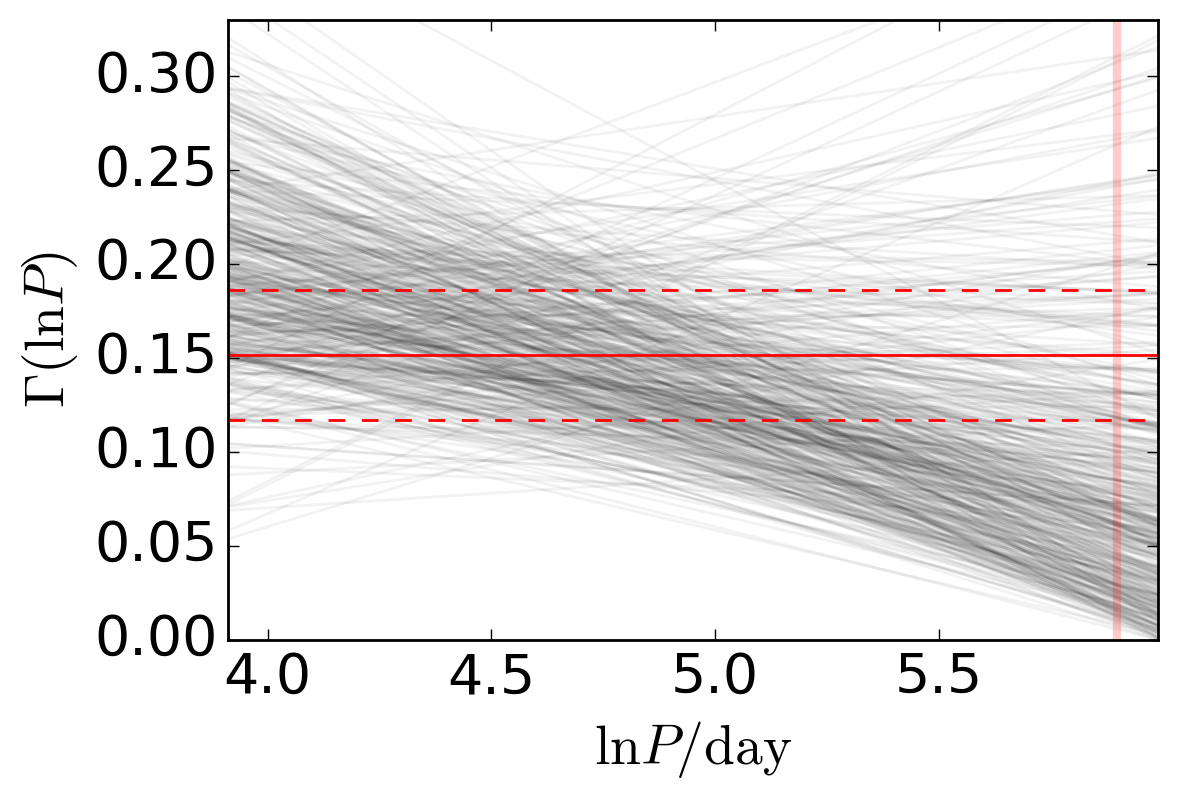

In [38]:
# First, plot the posterior samples.
x = np.linspace(lpmn, lpmx, 500)
chain = sampler.flatchain
for i in np.random.randint(len(chain), size=500):
    pl.plot(x, model(chain[i], x) / nstar, "k", alpha=0.05)

# Then plot the Petigura estimate as a red horizontal line.
pl.gca().axhline(mu, color="r")
pl.gca().axhline(mu+std, color="r", ls="--")
pl.gca().axhline(mu-std, color="r", ls="--")

# And indicate the location of Earth.
pl.gca().axvline(np.log(365.), color="r", alpha=0.2, lw=3)

pl.xlabel(r"$\ln P / \mathrm{day}$")
pl.ylabel(r"$\Gamma (\ln P)$")
pl.xlim(lpmn, lpmx)
pl.ylim(0, 0.33);

It's clear from this figure that—at the location of Earth—these two results are pretty inconsistent and the data *don't* support a uniform distribution.

Using these samples, we can compute the constraint on $\Gamma_\oplus$:

In [39]:
ge = np.array([model(p, np.log(365.)) for p in chain])
ge /= nstar
q = np.percentile(ge, [16, 50, 84])
e = np.diff(q)
Math(r"\Gamma_\oplus = {0:.3f} _{{-{1:.3f}}} ^{{+{2:.3f}}}".format(q[1], e[0], e[1]))

<IPython.core.display.Math object>

Compare this to Petigura et al.'s result:

In [40]:
Math(r"\Gamma_\oplus = {0:.3f} \pm {1:.3f}".format(mu, std))

<IPython.core.display.Math object>

Integrating these results over Petigura's bin, we get:

In [41]:
area = (lrmx - lrmn) * (np.log(400) - np.log(200))
Math(r"\Gamma_{{\oplus,\mathrm{{int}}}} = {0:.3f} \pm {1:.3f} \quad (\mathrm{{uniform}})".format(mu * area, std * area))

<IPython.core.display.Math object>

In [42]:
ge = np.array([model(p, np.log(365.)) * area for p in chain])
ge /= nstar
q = np.percentile(ge, [16, 50, 84])
e = np.diff(q)
Math(r"\Gamma_{{\oplus,\mathrm{{int}}}} = {0:.3f} _{{-{1:.3f}}} ^{{+{2:.3f}}} \quad (\mathrm{{linear}})"
     .format(q[1], e[0], e[1]))

<IPython.core.display.Math object>

## Dong & Zhu

Dong & Zhu fit a model of the form

$$\Gamma (\log_{10} P,\,\log_{10} R) = C\,\left(\frac{P}{10\,\mathrm{days}}\right)^{\beta}$$

and found (in the range $1\,R_\oplus \le R < 2\,R_\oplus$)

$$C = 0.66 \pm 0.08 \quad\mathrm{and}\quad \beta = -0.10 \pm 0.12 \quad.$$

Using

$$\Gamma (\ln P,\,\ln R) = \frac{1}{(\ln 10)^2} \Gamma (\log_{10} P,\,\log_{10} R) \quad,$$

we get the following result for $\Gamma_\oplus$:

In [43]:
K = 100000
C = 0.66 + 0.08 * np.random.randn(K)
beta = -0.10 + 0.12 * np.random.randn(K)
vals = C * (365. / 10) ** beta / np.log(10) ** 2
q = np.percentile(vals, [16, 50, 84])
Math(r"\Gamma_\oplus = {0:.3f} _{{-{1:.3f}}} ^{{+{2:.3f}}}".format(q[1], *(np.diff(q))))

<IPython.core.display.Math object>

## Comparison Plot

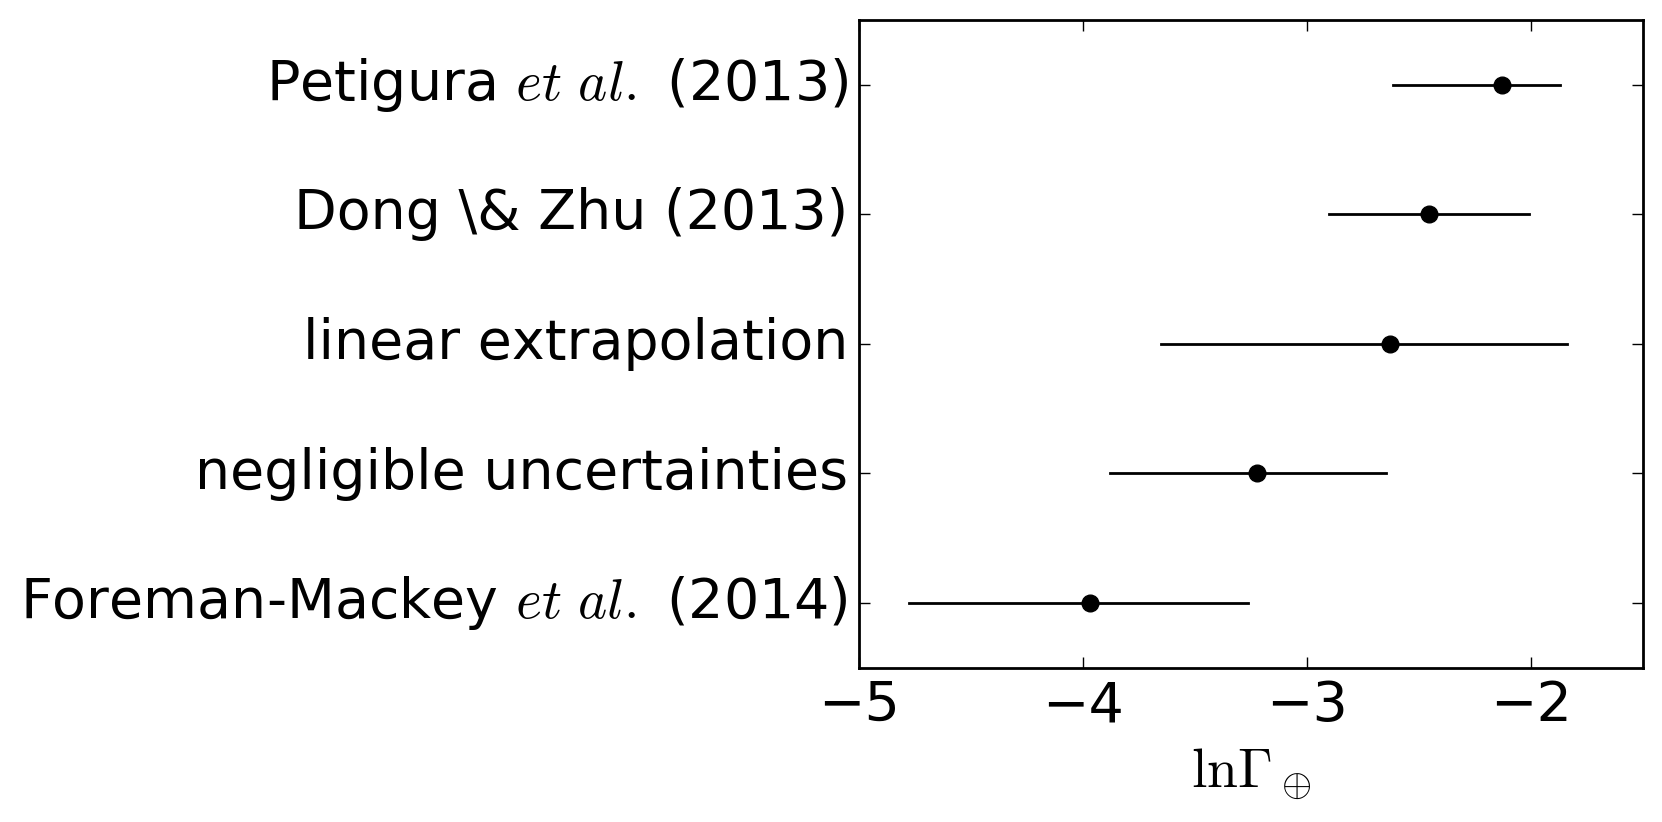

In [51]:
from matplotlib.ticker import MaxNLocator

values = [
    (r"Petigura ${et\,\,al.}$ (2013)", 0.119, 0.035, 0.046),
    (r"Dong \& Zhu (2013)", 0.086, 0.048, 0.031),
    (r"linear extrapolation", 0.072, 0.087, 0.046),
    (r"negligible uncertainties", 0.0397591956934, 0.0309881584307, 0.0190620520124),
    (r"Foreman-Mackey ${et\,\,al.}$ (2014)", 0.0188817594233, 0.0193141328059, 0.0104440671941),
]

fig = pl.figure(figsize=(8, 4))
for i, v in enumerate(values):
    pl.plot(np.log(v[1]), i, "ok")
    pl.plot(np.log([v[1]+v[2], v[1]-v[3]]), [i, i], "k")

pl.gca().set_yticklabels([""] + [v[0] for v in values])
# [l.set_rotation(90) for l in pl.gca().get_xticklabels()]
pl.xlabel(r"$\ln\Gamma_\oplus$")
fig.subplots_adjust(left=0.48, bottom=0.17, right=0.97, top=0.98)
pl.ylim(4.5, -0.5)
pl.gca().xaxis.set_major_locator(MaxNLocator(5))
pl.savefig("document/figures/comparison.pdf");

In [322]:
x = [0, 1]
np.polyval([1, 5], x)

array([5, 6])